# Speaker Identification

## Project Description

### Task

辨别声音来自哪类。

### Dataset

数据来自 [VoxCeleb2](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox2.html) ，取其一部分。

- training

    56666 个预处理后的带标签音频。

- testing

    4000 个预处理后不带标签的音频。

- label

    共 600 个类，每类代表一个说话人。

### Data Format

- `metadata.json`

    - `"n_mels"`

        每个 speaker 含有的音频（mel-spectrogram）数量。

    - `"speakers"`

        一个字典。

        - Key

            speaker name（例：`idxxxxxx`）。

        - Value

            音频路径和长度。`feature_path, mel_len`

- `testdata.json`

    格式同 `metadata.json`，只是 `"speakers"` 换为 `"utterances"` 。

- `mapping.json`

    字典，speaker name 到 speaker 数字 id [0, 599] 的映射，和 speaker 数字 id 到 speaker name 的映射。

- `uttr-{random string}.pt`

    音频数据。

### Method

- 每个音频每次用到随机取一段使用，长度为 `segment_len`，不足则补充小数值。

- Transformer 提取特征，然后通过全连接神经网络。

## Import Package

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import json
import random
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR

## Package Version

In [14]:
''' local
Python 3.10.4
matplotlib 3.5.2
numpy 1.22.3
torch 1.11.0
pandas 1.4.2
'''

''' Kaggle
Python 3.7.12
matplotlib 3.5.3
numpy 1.21.6
torch 1.12.0
pandas 1.3.5
'''
def package_version():

    ! python -V

    import pkg_resources
    import types

    poorly_named_packages = {
        "PIL": "Pillow",
        "sklearn": "scikit-learn"
    }   # package name is different to import name

    imports = []
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        imports.append(name)

    for x in pkg_resources.working_set:
        if x.project_name in imports and x.project_name != "pip":
            print(f"{x.project_name} {x.version}")

package_version()

Python 3.10.4
matplotlib 3.5.2
numpy 1.22.3
torch 1.11.0
pandas 1.4.2


## Configuration

In [15]:
class Config:
    # data path
    data_path = './Dataset/'
    metadata_path = './Dataset/metadata.json'
    mapping_path = './Dataset/mapping.json'
    testdata_path = './Dataset/testdata.json'

    # local or cloud
    if 'kaggle/working' in os.getcwd(): 
        at_cloud = True
        data_path = '/kaggle/input/ml2022spring-hw4/Dataset/'
        metadata_path = data_path + 'metadata.json'
        mapping_path =  data_path + 'mapping.json'
        testdata_path = data_path + 'testdata.json'
    else:
        at_cloud = False

    # environment
    device = 'cuda' if torch.cuda.is_available() else 'cpu'   # 类变量
    seed = 923
    model_save_path = './model.ckpt'

    # NN structure
    input_dim = 40
    output_dim = 600   # speaker number
    segment_len = 160   # 输入 Transformer 的特征向量序列长度。
    d_model = 128    # 输入 Transformer 特征向量的长度，由 mel 的 40 经 prenet 扩展到 80 。
    num_encoder_layer = 2
    dropout = 0.1
    nhead = 2

    # training
    n_example = 56666
    n_epoch = 300
    validation_ratio = 0.2
    batch_size = 64
    warmup_steps = 50
    n_worker = 0
    begin_saving_epoch = 100
    weight_decay = 1e-2   # 默认值

    # test
    num_segment = 5   # 5 random segment to 1 results

    # runing_test
    runing_test = True   # need be modified by hand
    if runing_test:
        n_example = 70
        n_epoch = 4
        begin_saving_epoch = 2

    if at_cloud:
        n_worker = 2

print(f"Using {Config.device} device")

Using cpu device


## Random Seed

In [16]:
def random_seed(seed): 
    torch.backends.cudnn.deterministic = True   # 卷积都使用默认的卷积算法
    torch.backends.cudnn.benchmark = False   # 关闭系统卷积算法选择优化（带随机性）
    np.random.seed(seed)   # 为随机算法设置种子。
    torch.manual_seed(seed)   # 为 CPU 设置种子。
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)   # 为所有 GPU 设置种子。

## Data Processing

In [17]:
def get_file(path):
    with open(path, 'r') as f:
        return json.load(f)

def split_train_validate(dataset):
    dataset_len = len(dataset)
    validate_len = int(dataset_len * Config.validation_ratio)
    train_len = dataset_len - validate_len
    train_set, validate_set = random_split(dataset, [train_len, validate_len], generator=torch.Generator().manual_seed(Config.seed))
    return train_set, validate_set

def get_segment(mel):
    if len(mel) > Config.segment_len:
        start_position = random.randint(0, len(mel) - Config.segment_len)
        mel = mel[start_position : start_position + Config.segment_len]
    else:
        add = Config.segment_len - len(mel)
        mel = torch.nn.functional.pad(mel, pad=(0, 0, 0, add), mode='constant', value=1e-8)   # a very small value
    return mel

## Data Intergration

In [18]:
class MyDataset(Dataset):
    def checkmode(self):
        if self.mode == 'training' or self.mode == 'validation':
            return True
        elif self.mode == 'test':
            return False
        else:
            exit(-1)

    def __init__(self, mode):
        self.mode = mode
        self.data = []

        if self.checkmode():
            self.metadata = get_file(Config.metadata_path)['speakers']
            self.speaker2id = get_file(Config.mapping_path)['speaker2id']
            count = 0
            for speaker in self.speaker2id.keys():
                count += 1
                if Config.runing_test and count > Config.n_example:
                    break
                for x in self.metadata[speaker]:
                    self.data.append([x['feature_path'], self.speaker2id[speaker]])   # [uttr filename, id]
        else:
            uttrs = get_file(Config.testdata_path)['utterances']
            count = 0
            for x in uttrs:
                count += 1
                if Config.runing_test and count > Config.n_example:
                    break
                self.data.append(x['feature_path'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.checkmode():
            feature_filename, id = self.data[index]
        else:
            feature_filename = self.data[index]

        mel = torch.load(os.path.join(Config.data_path, feature_filename))
        mel = get_segment(mel)

        if self.checkmode():
            return mel, id
        else:
            return mel

# dataset = MyDataset('training')
# train_set, validate_set = split_train_validate(dataset)
# train_loader = DataLoader(train_set, Config.batch_size, shuffle=True)
# validate_loader = DataLoader(validate_set, Config.batch_size, shuffle=True)
# for x in validate_loader:
#     mel, id = x
#     print(mel.shape)   # mel shape = (batch_size, segment_len, 40)
#     break

## Model Structure

In [19]:
class Classifier(nn.Module):
    def __init__(self, d_model=Config.d_model):
        super().__init__()

        self.prenet = nn.Linear(Config.input_dim, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, dim_feedforward=256, nhead=Config.nhead, dropout=Config.dropout)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=Config.num_encoder_layer)
        self.pred_layer = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Linear(256, Config.output_dim)
        )

    def forward(self, mels):
        '''
        mels: (batch_size, mel_length, 40)
        return: (batch_size, speaker_number)
        '''
        # out: (batch size, length, d_model)
        out = self.prenet(mels)
        # out: (length, batch size, d_model)
        out = out.permute(1, 0, 2)
        # The encoder layer expect features in the shape of (length, batch size, d_model).
        out = self.encoder(out)
        # out: (batch size, length, d_model)
        out = out.transpose(0, 1)
        # mean pooling
        # out: (batch size, d_model)
        stats = out.mean(dim=1)      
        # out: (batch size, n_spks) one-hat
        out = self.pred_layer(stats)
        return out

model = Classifier()
print(model)

Classifier(
  (prenet): Linear(in_features=40, out_features=128, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dro

## Learning Rate Schedule

In [20]:
def get_scheduler(optimizer: Optimizer, num_warmup_steps: int, num_training_steps: int, num_cycles: float = 0.5, last_epoch: int = -1):

    def lr_lambda(current_step):   # 为了使用参数，在其内定义函数。
        # Warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(
            max(1, num_training_steps - num_warmup_steps)
        )
        return max(
            0.0, 0.5 * (1.0 + np.cos(np.pi * float(num_cycles) * 2.0 * progress))
        )
    
    return LambdaLR(optimizer, lr_lambda, last_epoch)

## Training Loop

In [21]:
def training(model, train_loader, validate_loader):
    model = model.to(Config.device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=Config.weight_decay)
    scheduler = get_scheduler(optimizer, Config.warmup_steps, Config.n_epoch)

    train_loss_epoch = []
    validate_loss_epoch = []
    acc_epoch = []
    best_acc = - torch.inf

    for epoch in range(Config.n_epoch):
        # traning
        model.train()
        loss_batch = []

        for batch in train_loader:
            mels, labels = batch
            mels = mels.to(Config.device)
            labels = labels.to(Config.device)

            outs = model(mels)
            loss = criterion(outs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            loss_batch.append(loss.item())

        trian_loss = np.mean(loss_batch)
        train_loss_epoch.append(trian_loss)

        # validation
        model.eval()
        loss_batch = []
        acc_batch = []

        with torch.no_grad():
            for batch in validate_loader:
                mels, labels = batch
                mels = mels.to(Config.device)
                labels = labels.to(Config.device)

                outs = model(mels)
                loss = criterion(outs, labels)

                loss_batch.append(loss.item())
                preds = outs.argmax(1)
                t = torch.mean((preds == labels).float()).item()
                acc_batch.append(t)

        validate_loss = np.mean(loss_batch)
        acc = np.mean(acc_batch) 
        validate_loss_epoch.append(validate_loss)
        acc_epoch.append(acc)
        print(f"[epoch {epoch + 1}/{Config.n_epoch}] training loss = {trian_loss:.4f}, validation loss = {validate_loss:.4f}, acc = {acc:.4f} ")

        if acc > best_acc:
            best_acc = acc
            if epoch >= Config.begin_saving_epoch:
                torch.save(model.state_dict(), Config.model_save_path)
                print(f"[epoch {epoch + 1}/{Config.n_epoch}] ### model is saved at best_acc = {best_acc:.4f} ")
                
    return train_loss_epoch, validate_loss_epoch, acc_epoch

dataset = MyDataset('training')
train_set, validate_set = split_train_validate(dataset)
train_loader = DataLoader(train_set, Config.batch_size, shuffle=True, num_workers=Config.n_worker)
validate_loader = DataLoader(validate_set, Config.batch_size, shuffle=True, num_workers=Config.n_worker)
print('Begin training.')
begin = time.time()
train_loss_epoch, validate_loss_epoch, acc_epoch = training(model, train_loader, validate_loader)
end = time.time()
print('End.')

Begin training.
[epoch 1/4] training loss = 4.9592, validation loss = 4.0133, acc = 0.0472 
[epoch 2/4] training loss = 3.5390, validation loss = 3.0984, acc = 0.2009 
[epoch 3/4] training loss = 2.7088, validation loss = 2.4423, acc = 0.3447 
[epoch 3/4] ### model is saved at best_acc = 0.3447 
[epoch 4/4] training loss = 2.1595, validation loss = 2.0558, acc = 0.4448 
[epoch 4/4] ### model is saved at best_acc = 0.4448 
End.


In [22]:
best_training_loss = min(train_loss_epoch)
best_validation_loss = min(validate_loss_epoch)
best_acc = max(acc_epoch)
print(f'### best training loss = {best_training_loss:.4f}, best validation loss = {best_validation_loss:.4f}, best acc = {best_acc:.4f}')
total = (end - begin) / 60 / 60 # hours
print(f'### Training total costs {total:.2f} hours.')

### best training loss = 2.1595, best validation loss = 2.0558, best acc = 0.4448
### Training total costs 0.05 hours.


## Loss Curve

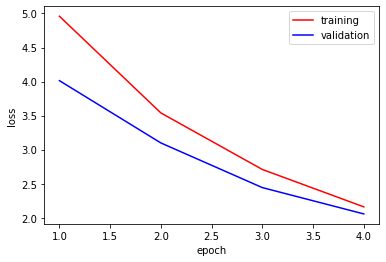

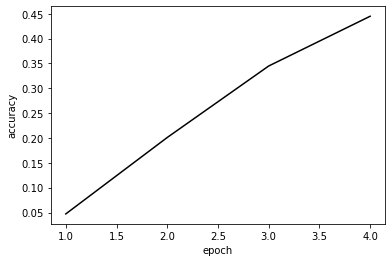

In [23]:
x = range(1, Config.n_epoch + 1)

plt.figure()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(x, train_loss_epoch, 'r-', label='training')
plt.plot(x, validate_loss_epoch, 'b-', label='validation')
plt.legend()
plt.show()

plt.figure()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(x, acc_epoch, 'k-')
plt.show()

## Test

In [28]:
def save_prediction(result, mels_name):
    id2speaker = get_file(Config.mapping_path)['id2speaker']
    speakers = []
    for id in result:
        speakers.append(id2speaker[str(id)])
    df = pd.DataFrame(columns=['Id', 'Category'], data={'Id':mels_name, 'Category': speakers})
    df.to_csv('prediction.csv', index=False)
    print('prediction saved.')

def test(model, test_loader):
    model = model.to(Config.device)

    predictions = []
    result = []
    model.eval()
    with torch.no_grad():
        for _ in range(Config.num_segment):
            preds = []
            for batch in test_loader:
                mels = batch
                mels = mels.to(Config.device)
                outs = model(mels)
                pred_labels = outs.argmax(1).tolist()
                preds.extend(pred_labels)

            predictions.append(preds)

        predictions = list(zip(*predictions))

        for x in predictions:
            result.append(max(x, key=x.count))
    return result

model = Classifier()
model.load_state_dict(torch.load(Config.model_save_path))
test_set = MyDataset('test')
testloader = DataLoader(test_set, batch_size=Config.batch_size, shuffle=False)
result = test(model, testloader)
mels_name = test_set.data
save_prediction(result, mels_name)

prediction saved.
